# 5.2 - Recordatorio distribución de Poisson

$$X \sim Poisson(\lambda)$$

$$P(X=k)=\frac{\lambda ^{k}e^{-\lambda }}{k!}$$

para $k = 0, 1, 2,..$

La distribución de Poisson es una distribución de probabilidad discreta que expresa, a partir de una frecuencia de ocurrencia media, la probabilidad de que ocurra un determinado número de eventos durante cierto período de tiempo. Concretamente, se especializa en la probabilidad de ocurrencia de sucesos con probabilidades muy pequeñas, o sucesos raros. 

In [1]:
from scipy.stats import poisson        # distribucion de poisson

import pylab as plt
import seaborn as sns

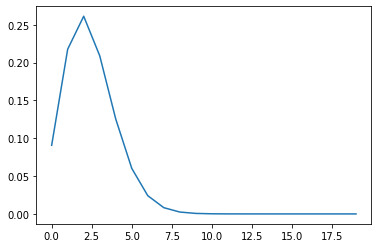

In [2]:
x=[i for i in range(20)]  # nº de sucesos, eje x

lamb=2.4  # media de ocurrencia

y=[poisson.pmf(x, lamb) for x in x]   # evaluacion de la pmf para cada nº de sucesos, eje y

plt.plot(x, y);

# Modelo de Dixon-Coles (Maher)

La idea detrás del modelo de [Dixon-Coles](http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf) es que el gol es un evento raro en un partido de fútbol y se podría usar la distribución de Poisson para predecir el resultado de un partido.


Para el nº de goles X del equipo local i-esimo y el nº de goles Y del equipo visitante j-esimo se tendria:

$$X \sim Poisson(\lambda)$$

$$P(X=k)=\frac{\lambda^{k}e^{-\lambda}}{k!}$$

$$Y \sim Poisson(\mu)$$

$$P(Y=k)=\frac{\mu^{k}e^{-\mu}}{k!}$$

donde:

$\lambda = \gamma\alpha_{i}\beta_{j} = \exp^{(\gamma+\alpha_{i}+\beta_{j})}$

$\mu = \alpha_{j}\beta_{i}  = \exp^{(\alpha_{j}+\beta_{i})}$

El modelo introduce varios parámetros para relacionar los equipos y los partidos, un parámetro llamado `gamma` es el parámetro de jugar en casa, los parámetros llamados `alfa` son los parámetros de ataque de cada equipo y los parámetros `beta` son los de defensa de cada equipo.

Asi pues, la funcion que define el partido, la funcion principal del modelo, nuestro `predict` es:

$$P(X=x, Y=y)=\frac{\lambda^{x}e^{-\lambda}}{x!} · \frac{\mu^{y}e^{-\mu}}{y!}$$

La funcion de coste o perdida, nuestro `fit`, en este caso se calcula con la [estamacion maximo verosimil](https://es.wikipedia.org/wiki/M%C3%A1xima_verosimilitud). Sería el productorio en todo el espacio de probabilidad de la funcion principal, llamada funcion de verosimilitud.

$$L(X=x, Y=y)=\prod_{i=1}^{n}\frac{\lambda^{x}e^{-\lambda}}{x!} · \frac{\mu^{y}e^{-\mu}}{y!}$$

Debido a la regla de la cadena, minimizar esta funcion es muy costoso, por lo que se realiza un truco matematico que consiste en aplicar el logaritmo. Esto es debido a la regla de los logaritmos: $log(a·b)=log(a)+log(b)$. Por tanto, la nueva funcion a ser optimizada (maximizada) es llamada log-verosimilitud.

$$l(X=x, Y=y)=\sum_{i=1}^{n}\log(\frac{\lambda^{x}e^{-\lambda}}{x!}) + \log(\frac{\mu^{y}e^{-\mu}}{y!})$$

La idea es: dados los resultados de los partidos de futbol, estimar el parametro de jugar en casa `gamma`, los parametros de ataque para cada equipo `alfa` y los parametros de defensa para cada equipo `beta`.

### Datos

Veamos primero la extracción de datos desde [aqui](https://www.football-data.co.uk/).

In [3]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

In [4]:
df=pd.read_csv('https://www.football-data.co.uk/mmz4281/0001/SP1.csv')

df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA
0,SP1,09/09/00,Barcelona,Malaga,2,1,H,2,0,H,1.28,3.90,7.90,1.25,4.3,8.0,1.35,3.75,8.0,1.30,4.33,8.50,1.28,4.50,8.00
1,SP1,09/09/00,La Coruna,Ath Bilbao,2,0,H,0,0,D,1.51,3.20,6.20,1.55,3.3,4.5,1.55,3.25,5.5,1.53,3.50,5.50,1.57,3.50,5.00
2,SP1,09/09/00,Real Madrid,Valencia,2,1,H,0,0,D,1.65,3.20,4.10,1.60,3.2,4.2,1.55,3.50,5.0,1.67,3.30,4.75,1.66,3.30,4.50
3,SP1,09/09/00,Sociedad,Santander,2,2,D,0,0,D,1.85,3.15,3.45,1.80,3.0,3.5,1.70,3.40,4.0,1.85,3.25,3.80,1.80,3.25,3.75
4,SP1,09/09/00,Zaragoza,Espanol,1,2,A,0,0,D,1.70,3.10,4.30,1.70,3.1,3.8,1.70,3.20,4.3,1.73,3.25,4.33,1.72,3.20,4.33


In [5]:
df=df[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]

df.shape

(380, 5)

In [6]:
for i in range(1, 22):
    
    year=''
    if i<9:
        year=f'0{i}0{i+1}'
    elif i==9:
        year=f'0{i}{i+1}'
    else:
        year=f'{i}{i+1}'
    
    print(year)
    new_df=pd.read_csv(f'https://www.football-data.co.uk/mmz4281/{year}/SP1.csv',
                      error_bad_lines=False,
                      warn_bad_lines=False)[['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']]
    
    df=pd.concat([df, new_df])
    
df.shape

0102
0203
0304
0405
0506
0607
0708
0809
0910
1011
1112
1213
1314
1415
1516
1617
1718
1819
1920
2021
2122


(8115, 5)

In [8]:
df.HomeTeam=df.HomeTeam.apply(lambda x: x.lower().replace(' ', '_'))

df.AwayTeam=df.AwayTeam.apply(lambda x: x.lower().replace(' ', '_'))

df.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
0,09/09/00,barcelona,malaga,2,1
1,09/09/00,la_coruna,ath_bilbao,2,0
2,09/09/00,real_madrid,valencia,2,1
3,09/09/00,sociedad,santander,2,2
4,09/09/00,zaragoza,espanol,1,2


In [9]:
df.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG
242,19/02/2022,real_madrid,alaves,3,0
243,20/02/2022,espanol,sevilla,1,1
244,20/02/2022,valencia,barcelona,1,4
245,20/02/2022,betis,mallorca,2,1
246,20/02/2022,ath_bilbao,sociedad,4,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8115 entries, 0 to 246
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      8115 non-null   object
 1   HomeTeam  8115 non-null   object
 2   AwayTeam  8115 non-null   object
 3   FTHG      8115 non-null   int64 
 4   FTAG      8115 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 380.4+ KB


## Modelo de Poisson

**fit**

In [11]:
import numpy as np

from scipy.optimize import minimize # minimizar funciones

In [13]:
# funcion de perdida, log-verosimilitud, funcion a MAXIMIZAR cuidao

def loglike(x, y, alfai, betai, alfaj, betaj, gamma):
    '''
    x, goles de local
    y, goles de visitante
    alfai, ataque local
    betai, defensa local
    alfaj, ataque visitante
    betaj, defensa visitante
    gamma jugar en casa
    '''
    
    # medias, es aqui donde podriamos añadir valores exogenos(clima, distancia recorrida, altura...)
    lamb=np.exp(gamma+alfai+betaj)
    mu=np.exp(alfaj+betai)
    
    l=(np.log(poisson.pmf(x, lamb))+np.log(poisson.pmf(y, mu)))
    
    return l
    

In [26]:
# funcion parea obtener esos parametros gamma, alfa, beta

def fit(data):

    #data=df.iloc[-30:]

    equipos=np.sort(data.HomeTeam.unique())

    n_equipos=len(equipos)


    # valores iniciales de los parametros
    val_inicial=np.concatenate((np.random.uniform(0, 1, (n_equipos)),  # alfas ataque
                                np.random.uniform(0, -1, (n_equipos)), # betas defensa
                                np.array([1.0])))                      # gamma factor casa


    def menos_loglike(params):  # funcion a minimizar

        alfa_coefs=dict(zip(equipos, params[:n_equipos]))

        beta_coefs=dict(zip(equipos, params[n_equipos:(2*n_equipos)]))

        gamma=params[-1]


        log_like=[loglike(fila.FTHG,
                          fila.FTAG,
                          alfa_coefs[fila.HomeTeam],
                          beta_coefs[fila.HomeTeam],
                          alfa_coefs[fila.AwayTeam],
                          beta_coefs[fila.AwayTeam],
                          gamma) for fila in data.itertuples()] # seleccion por filas

        return -sum(log_like)


    optimizacion=minimize(menos_loglike,
                          val_inicial,
                          options={'disp': True, 'maxiter':100},
                          method='trust-constr',
                          constraints=[{'type': 'eq', 'fun':lambda x: sum(x[:20])-20}]) # restriccion que viene del paper
    
    
    return dict(zip(['alfa_'+equipo for equipo in equipos]+['beta_'+equipo for equipo in equipos]+['gamma'],
             optimizacion.x))

In [27]:
%%time

data=df.iloc[-150:]

params=fit(data)

params

`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 2982, CG iterations: 225, optimality: 1.14e-05, constraint violation: 0.00e+00, execution time: 6e+01 s.
CPU times: user 1min 19s, sys: 59.9 s, total: 2min 19s
Wall time: 1min


{'alfa_alaves': 0.28834895159019686,
 'alfa_ath_bilbao': 0.5497324891878975,
 'alfa_ath_madrid': 0.9547095228812571,
 'alfa_barcelona': 0.8147917344910232,
 'alfa_betis': 0.9490719687623022,
 'alfa_cadiz': 0.25282663038949416,
 'alfa_celta': 0.544067670290958,
 'alfa_elche': 0.668155136763966,
 'alfa_espanol': 0.5796922068877818,
 'alfa_getafe': 0.562507134672453,
 'alfa_granada': 0.5466517780872681,
 'alfa_levante': 0.23484988144268798,
 'alfa_mallorca': 0.302023087858535,
 'alfa_osasuna': 0.04749997136160415,
 'alfa_real_madrid': 0.7514399388998255,
 'alfa_sevilla': 0.561505136541232,
 'alfa_sociedad': -0.029863653884659922,
 'alfa_valencia': 0.6754597059760443,
 'alfa_vallecano': 0.016345727596479096,
 'alfa_villarreal': 0.9346725271240014,
 'beta_alaves': -0.10278753787189047,
 'beta_ath_bilbao': -0.5756713689065417,
 'beta_ath_madrid': -0.1911065839352587,
 'beta_barcelona': -0.5468733884629845,
 'beta_betis': -0.42569149465480094,
 'beta_cadiz': -0.23509986200706506,
 'beta_celta

In [28]:
# valor de jugar en casa

np.exp(0.24908639770637117)

1.2828528638270271

**predict**

In [29]:
# Funciones para prediccion

def predict_matrix(params, local, visitante, g_max):  
    
    # se definen lambda y mu para prediccion 
    
    # media equipo local
    lamb=np.exp(params['gamma']+params['alfa_'+local]+params['beta_'+visitante])
    
    # media equipo visitante
    mu=np.exp(params['alfa_'+visitante] + params['beta_'+local])
    
    avgs=[lamb,mu]

    pred=[[poisson.pmf(i,avg) for i in range(0, g_max+1)] for avg in avgs]
    
    matriz=np.outer(np.array(pred[0]), np.array(pred[1]))

    return matriz

In [30]:
partido=predict_matrix(params, 'vallecano', 'real_madrid', 9)

In [31]:
pd.DataFrame(partido)

,0,1,2,3,4,5,6,7,8,9
0,2.067320e-01,2.453236e-01,1.455597e-01,5.757732e-02,1.708139e-02,4.054009e-03,8.017983e-04,1.359248e-04,2.016231e-05,2.658456e-06
1,8.055464e-02,9.559215e-02,5.671839e-02,2.243542e-02,6.655887e-03,1.579674e-03,3.124266e-04,5.296410e-05,7.856393e-06,1.035887e-06
2,1.569435e-02,1.862409e-02,1.105037e-02,4.371063e-03,1.296757e-03,3.077658e-04,6.086965e-05,1.031892e-05,1.530651e-06,2.018205e-07
3,2.038473e-03,2.419004e-03,1.435285e-03,5.677389e-04,1.684303e-04,3.997440e-05,7.906101e-06,1.340281e-06,1.988097e-07,2.621361e-08
4,1.985765e-04,2.356457e-04,1.398174e-04,5.530591e-05,1.640753e-05,3.894080e-06,7.701675e-07,1.305626e-07,1.936692e-08,2.553581e-09
5,1.547536e-05,1.836421e-05,1.089617e-05,4.310070e-06,1.278663e-06,3.034713e-07,6.002028e-08,1.017494e-08,1.509292e-09,1.990043e-10
6,1.005014e-06,1.192625e-06,7.076289e-07,2.799084e-07,8.304005e-08,1.970830e-08,3.897890e-09,6.607896e-10,9.801779e-11,1.292391e-11
7,5.594445e-08,6.638786e-08,3.939040e-08,1.558119e-08,4.622452e-09,1.097069e-09,2.169774e-10,3.678307e-11,5.456192e-12,7.194139e-13
8,2.724896e-09,3.233565e-09,1.918594e-09,7.589158e-10,2.251465e-10,5.343513e-11,1.056835e-11,1.791599e-12,2.657557e-13,3.504061e-14
9,1.179751e-10,1.399980e-10,8.306604e-11,3.285745e-11,9.747776e-12,2.313488e-12,4.575595e-13,7.756775e-14,1.150596e-14,1.517092e-15


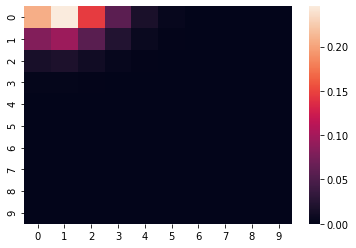

In [32]:
sns.heatmap(partido);

In [33]:
uno=np.sum(np.tril(partido, -1))

empate=np.sum(np.diag(partido))

dos=np.sum(np.triu(partido, 1))

In [34]:
uno, empate, dos

(0.12144900047789027, 0.3139589914239235, 0.5645914865824959)

In [35]:
uno+empate+dos

0.9999994784843096

In [36]:
def predict_proba(params, local, visitante, g_max):
    
    partido=predict_matrix(params, local, visitante, g_max)

    uno=np.sum(np.tril(partido, -1))

    empate=np.sum(np.diag(partido))

    dos=np.sum(np.triu(partido, 1))
    
    return uno, empate, dos

In [37]:
predict_proba(params, 'vallecano', 'real_madrid', 9)  # probabilidad (1, X, 2)

(0.12144900047789027, 0.3139589914239235, 0.5645914865824959)

In [38]:
def predict(params, local, visitante, g_max):
    
    prob=predict_proba(params, local, visitante, g_max)
    
    return prob.index(max(prob))

In [39]:
predict(params, 'vallecano', 'real_madrid', 9) # etiquetas: 0-gana local , 1-empate, 2-gana visitante

2

In [43]:
# cuotas

[1/e for e in predict_proba(params, 'vallecano', 'real_madrid', 9)]

[8.233908851164646, 3.185129355476075, 1.7711921340738883]

**Walk-Forward BackTesting**

![wfbt](images/wfbt.gif)